# **Time Series**

## About the Data
In this notebook, we will be working with 5 data sets:
* (CSV) Facebook's stock price daily throughout 2018 (obtained using the
stock_analysis
 package).
* (CSV) Facebook's OHLC stock data from May 20, 2019 - May 24, 2019 per minute from Nasdaq.com.
* (CSV) melted stock data for Facebook from May 20, 2019 - May 24, 2019 per minute from Nasdaq.com.
* (DB) stock opening prices by the minute for Apple from May 20, 2019 - May 24, 2019 altered to have seconds in the time from Nasdaq.com.
* (DB) stock opening prices by the minute for Facebook from May 20, 2019 - May 24, 2019 from Nasdaq.com

## Setup

In [ ]:
import numpy as np
import pandas as pd

fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True).assign(
  trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


## Time-based selection and filtering
Remember, when we have a DatetimeIndex
, we can use datetime slicing. We can provide a range of dates. We only get three days back because the stock market is
closed on the weekends:

In [ ]:
fb['2018-10-11':'2018-10-15']

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.1600,153.35,35338901,low
2018-10-12,156.73,156.89,151.2998,153.74,25293492,low
2018-10-15,153.32,155.57,152.5500,153.52,15433521,low


 We can select ranges of months and quarters:


In [ ]:
fb['2018-q1'].equals(fb['2018-01':'2018-03'])


<ipython-input-3-f01e3c270a70>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-q1'].equals(fb['2018-01':'2018-03'])


True

 The
first()
 method will give us a specified length of time from the beginning of the time series. Here, we ask for a week. January 1, 2018 was a holiday—meaning the
 market was closed. It was also a Monday, so the week here is only four days:

In [ ]:
fb.first('1W') # .first() 1W first week

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low


In [ ]:
fb.last('1W') # .last() 1W last week

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


 For the next few examples, we need datetimes, so we will read in the stock data per minute file:


In [ ]:
stock_data_per_minute = pd.read_csv(
   'fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True,
   date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M') # the format is changed to year month day hour minute
) # this lets us get the stock data per minute

stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.6200,181.6200,181.6200,181.6200,159049.0
2019-05-20 09:31:00,182.6100,182.6100,182.6100,182.6100,468017.0
2019-05-20 09:32:00,182.7458,182.7458,182.7458,182.7458,97258.0
2019-05-20 09:33:00,182.9500,182.9500,182.9500,182.9500,43961.0
2019-05-20 09:34:00,183.0600,183.0600,183.0600,183.0600,79562.0


 We can use the
Grouper
 to roll up our data to the daily level along with
first
 and
last
 :

In [ ]:
stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
   'open': 'first', # align open with first to get the starting data for opening price
   'high': 'max',
   'low': 'min',
   'close': 'last', # align close with last to get the finalizing data for opening price
   'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.1800,181.6200,182.72,10044838.0
2019-05-21,184.53,185.5800,183.9700,184.82,7198405.0
2019-05-22,184.81,186.5603,184.0120,185.32,8412433.0
2019-05-23,182.50,183.7300,179.7559,180.87,12479171.0
2019-05-24,182.33,183.5227,181.0400,181.06,7686030.0


The
 at_time()
 method allows us to pull out all datetimes that match a certain time. Here, we can grab all the rows from the time the stock market opens (9:30 AM):

In [ ]:
stock_data_per_minute.at_time('9:30') # at_time() lets us get the data of a specific time

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.0
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.0
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.0
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.0
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.0


We can use
between_time()
 to grab data for the last two minutes of trading daily

In [ ]:
stock_data_per_minute.between_time('15:59', '16:00') # between_time() lets us get the date between a timeframe

,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.915,182.915,182.915,182.915,134569.0
2019-05-20 16:00:00,182.720,182.720,182.720,182.720,1113672.0
2019-05-21 15:59:00,184.840,184.840,184.840,184.840,61606.0
2019-05-21 16:00:00,184.820,184.820,184.820,184.820,801080.0
2019-05-22 15:59:00,185.290,185.290,185.290,185.290,96099.0
2019-05-22 16:00:00,185.320,185.320,185.320,185.320,1220993.0
2019-05-23 15:59:00,180.720,180.720,180.720,180.720,109648.0
2019-05-23 16:00:00,180.870,180.870,180.870,180.870,1329217.0
2019-05-24 15:59:00,181.070,181.070,181.070,181.070,52994.0


On average, are more shares traded within the first 30 minutes of trading or in the last 30 minutes? We can combine
from the aggregation.ipynb notebook to answer this question. For the week in question, more are traded on average around opening time than closing time:

In [ ]:
shares_traded_in_first_30_min = stock_data_per_minute\
  .between_time('9:30', '10:00')\
  .groupby(pd.Grouper(freq='1D'))\
  .filter(lambda x: (x.volume > 0).all())\
  .volume.mean() # this lets us get the shares traded in first 30 min
shares_traded_in_last_30_min = stock_data_per_minute\
  .between_time('15:30', '16:00')\
  .groupby(pd.Grouper(freq='1D'))\
  .filter(lambda x: (x.volume > 0).all())\
  .volume.mean() # this lets us get the shares traded in last 30 min

# significant difference in trading activity
shares_traded_in_first_30_min - shares_traded_in_last_30_min

18592.967741935485

 In cases where time doesn't matter, we can normalize the times to midnight:

In [ ]:
pd.DataFrame(
  dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())
).head()

,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


Note that we can also use
normalize()
 on a
Series
 object after accessing the
dt
 attribute

In [ ]:
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

##  Shifting for lagged data
We can use
shift()
 to create some lagged data. By default, the shift will be one period. For example, we can use
shift()
 to create a new column that indicates the
 previous day's closing price. From this new column, we can calculate the price change due to after hours trading (after the close one day right up to the open the following
 day):

In [ ]:
fb.assign(
  prior_close=lambda x: x.close.shift(), #.shift() to get the previous day's closing price
  after_hours_change_in_price=lambda x: x.open - x.prior_close, # prior_close now allows us to subtract it from opening price
  abs_change=lambda x: x.after_hours_change_in_price.abs() # to get the after_hours_change_in_price, now convert to absolute value
).nlargest(5, 'abs_change')

,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


The
tshift()
 method will shift the DatetimeIndex
 rather than the data. However, if the goal is to to add/subtract time we can use pd.Timedelta :


In [ ]:
pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')


DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

When working with stock data, we only have data for the dates the market was open. We can use
our data. For September 2018, this is September 4th:

In [ ]:
fb['2018-09'].first_valid_index() # first_valid_index() yields first entry of non-null data

<ipython-input-33-d8ca41528993>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-09'].first_valid_index()


Timestamp('2018-09-04 00:00:00')

 Conversely, we can use
last_valid_index()
 to get the last entry of non-null data. For September 2018, this is September 28th

In [ ]:
fb['2018-09'].last_valid_index() # last_valid_index() yields last entry of non-null data

<ipython-input-5-2d4b219bfd40>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  fb['2018-09'].last_valid_index() # last_valid_index() yields last entry of non-null data


Timestamp('2018-09-28 00:00:00')

We can use
asof()
 to find the last non-null data before the point we are looking for, if it isn't in the index. From the previous result, we know that the market was not open
 on September 30th. It also isn't in the index:

In [ ]:
fb.index.contains('2018-09-30')

AttributeError: 'DatetimeIndex' object has no attribute 'contains'

If we ask for it, we will get the data from the index we got from
fb['2018-09'].last_valid_index()
, which was September 28th

In [ ]:
fb.asof('2018-09-30')

open                168.33
high                168.79
low                 162.56
close               164.46
volume            34265638
trading_volume         low
Name: 2018-09-30 00:00:00, dtype: object

##  Differenced data
Using the
diff()
 method is a quick way to calculate the difference between the data and a lagged version of it. By default, it will yield the result of
data.shift()
:

In [ ]:
(
  fb.drop(columns='trading_volume') - fb.drop(columns='trading_volume').shift()
).equals(
  fb.drop(columns='trading_volume').diff() #.diff()
) # quick way to calculate the difference between the data and a lagged version of it

True

 We can use this to see how Facebook stock changed day-over-day:


In [ ]:
fb.drop(columns='trading_volume').diff().head() # quick way to calculate the difference between the data and a lagged version of it

,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.7800,3.25,-1265340.0
2018-01-04,3.02,1.43,2.7696,-0.34,-3005667.0
2018-01-05,0.69,0.69,0.8304,2.52,-306361.0
2018-01-08,1.61,2.00,1.4000,1.43,4420191.0


 We can specify the number of periods, can be any positive or negative integer:


In [ ]:
fb.drop(columns='trading_volume').diff(-3).head()


,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.3800,-5.43,4577368.0
2018-01-03,-5.32,-4.12,-5.0000,-3.61,-1108163.0
2018-01-04,-3.80,-2.59,-3.0004,-3.54,1487839.0
2018-01-05,-1.35,-0.99,-0.7000,-0.99,3044641.0
2018-01-08,-1.20,0.50,-1.0500,0.51,8406139.0


## Resampling

 Sometimes the data is at a granularity that isn't conducive to our analysis. Consider the case where we have data per minute for the full year of 2018. Let's see what happens
 if we try to plot this.

 Plotting will be covered in the next module, so don't worry too much about the code.

 First, we import
matplotlib
 for plotting:

In [ ]:
import matplotlib.pyplot as plt #matplotlib.pyplot as plt for plotting

Then we will look at the plot at the minute level and at the daily aggregated level (summed):


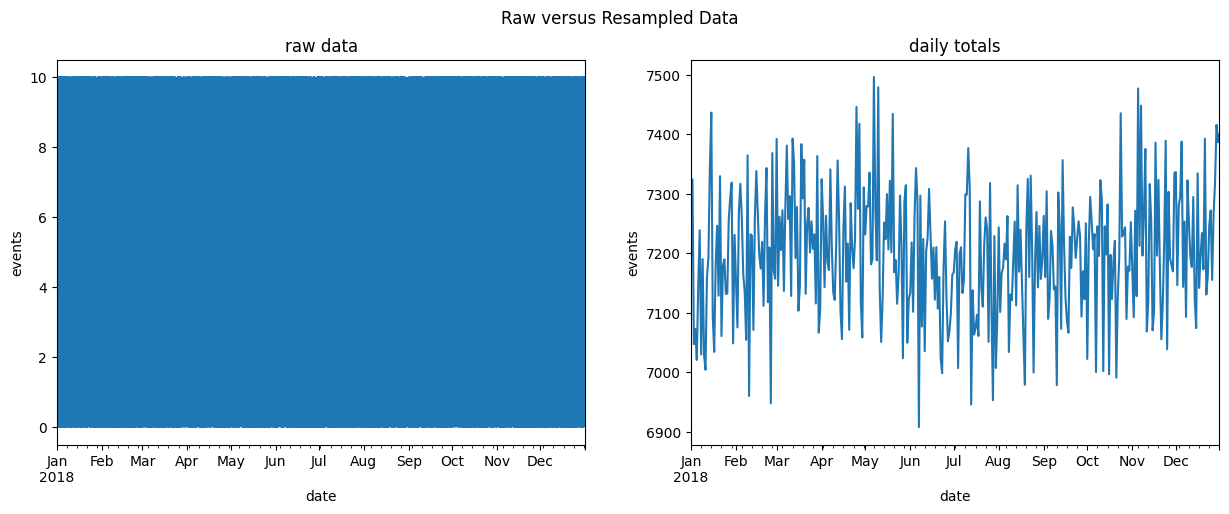

In [ ]:
np.random.seed(0) # get random seed and include index to get the certain same results
index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)
raw = pd.DataFrame(
  np.random.uniform(0, 10, size=index.shape[0]), index=index
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')
for ax in axes:
  ax.set_xlabel('date')
  ax.set_ylabel('events')
plt.suptitle('Raw versus Resampled Data')
plt.show()

 The plot on the left has so much data we can't see anything. However, when we aggregate to the daily totals, we see the data. We can alter the granularity of the data we are
 working with using resampling. Recall our minute-by-minute stock data:

In [ ]:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.6200,181.6200,181.6200,181.6200,159049.0
2019-05-20 09:31:00,182.6100,182.6100,182.6100,182.6100,468017.0
2019-05-20 09:32:00,182.7458,182.7458,182.7458,182.7458,97258.0
2019-05-20 09:33:00,182.9500,182.9500,182.9500,182.9500,43961.0
2019-05-20 09:34:00,183.0600,183.0600,183.0600,183.0600,79562.0


 We can resample this to get to a daily frequency:


In [ ]:
stock_data_per_minute.resample('1D').agg({
  'open': 'first', #.resample() for adjusting it to a daily frequency
  'high': 'max',
  'low': 'min',
  'close': 'last',
  'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.1800,181.6200,182.72,10044838.0
2019-05-21,184.53,185.5800,183.9700,184.82,7198405.0
2019-05-22,184.81,186.5603,184.0120,185.32,8412433.0
2019-05-23,182.50,183.7300,179.7559,180.87,12479171.0
2019-05-24,182.33,183.5227,181.0400,181.06,7686030.0


 We can downsample to quarterly data:


In [ ]:
fb.resample('Q').mean() # quarterly data

<ipython-input-49-f6fd3d834d43>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fb.resample('Q').mean()


,open,high,low,close,volume
date,,,,,
2018-03-31,179.472295,181.794659,177.040428,179.551148,3.292640e+07
2018-06-30,180.373770,182.277689,178.595964,180.704688,2.405532e+07
2018-09-30,180.812130,182.890886,178.955229,181.028492,2.701982e+07
2018-12-31,145.272460,147.620121,142.718943,144.868730,2.697433e+07


We can also use apply(). Here, we show the quarterly change from start to end:

In [ ]:
fb.drop(columns='trading_volume').resample('Q').apply(
  lambda x: x.last('1D').values - x.first('1D').values
) # after resampling to quarterly data, we apply it to see the change from start to end

date
2018-03-31    [[-22.53, -20.160000000000025, -23.41000000000...
2018-06-30    [[39.50999999999999, 38.399700000000024, 39.84...
2018-09-30    [[-25.039999999999992, -28.659999999999997, -2...
2018-12-31    [[-28.580000000000013, -31.24000000000001, -31...
Freq: Q-DEC, dtype: object

 Consider the following melted stock data by the minute. We don't see the OHLC data directly:


In [ ]:
melted_stock_data = pd.read_csv('melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()

,price
date,
2019-05-20 09:30:00,181.6200
2019-05-20 09:31:00,182.6100
2019-05-20 09:32:00,182.7458
2019-05-20 09:33:00,182.9500
2019-05-20 09:34:00,183.0600


We can use the
 ohlc()
 method after resampling to recover the OHLC columns

In [ ]:
melted_stock_data.resample('1D').ohlc()['price'] #.ohlc() for recovering the ohlc columns for price
# dont forget to resample it on the daily

,open,high,low,close
date,,,,
2019-05-20,181.62,184.1800,181.6200,182.72
2019-05-21,184.53,185.5800,183.9700,184.82
2019-05-22,184.81,186.5603,184.0120,185.32
2019-05-23,182.50,183.7300,179.7559,180.87
2019-05-24,182.33,183.5227,181.0400,181.06


 Alternatively, we can upsample to increase the granularity. Note this will introduce NaN values:


In [ ]:
fb.resample('6H').asfreq().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.0,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.0,low


 There are many ways to handle these  NaN
 values. We can forward-fill with
pad()
:


In [ ]:
fb.resample('6H').pad().head() #.pad() lets us forward-fill NaN values


<ipython-input-61-39179f05e435>:1: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  fb.resample('6H').pad().head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 18:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


 We can specify a specific value or a method with fillna():


In [ ]:
fb.resample('6H').fillna('nearest').head() # or use fillna() with the nearest value

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


We can use
asfreq()
 and
assign()
 to specify the action per column:

In [ ]:
fb.resample('6H').asfreq().assign(
  volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
  close=lambda x: x.close.fillna(method='ffill'), # carry forward
  # take the closing price if these aren't available
  open=lambda x: np.where(x.open.isnull(), x.close, x.open),
  high=lambda x: np.where(x.high.isnull(), x.close, x.high),
  low=lambda x: np.where(x.low.isnull(), x.close, x.low)
).head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.0,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.0,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.0,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.0,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.0,low


## Merging

 We saw merging examples the **querying_and_merging notebook**. However, they all matched based on keys. With time series, it is possible that they are so granular that we
 never have the same time for multiple entries. Let's work with some stock data at different granularities:

In [ ]:
# setup database
import sqlite3
with sqlite3.connect('stocks.db') as connection:
    fb_prices = pd.read_sql(
        'SELECT * FROM fb_prices', connection,
        index_col='date', parse_dates=['date']
    )
    aapl_prices = pd.read_sql(
        'SELECT * FROM aapl_prices', connection,
        index_col='date', parse_dates=['date']
    )

The Facebook prices are at the minute granularity:


In [ ]:
fb_prices.index.second.unique() #.index.second.unique() shows us that the prices dont change by seconds

Int64Index([0], dtype='int64', name='date')

 However, the Apple prices have information for the second:


In [ ]:
aapl_prices.index.second.unique() # on the other hand, apple changes in certain seconds


Int64Index([ 0, 52, 36, 34, 55, 35,  7, 12, 59, 17,  5, 20, 26, 23, 54, 49, 19,
            53, 11, 22, 13, 21, 10, 46, 42, 38, 33, 18, 16,  9, 56, 39,  2, 50,
            31, 58, 48, 24, 29,  6, 47, 51, 40,  3, 15, 14, 25,  4, 43,  8, 32,
            27, 30, 45,  1, 44, 57, 41, 37, 28],
           dtype='int64', name='date')

We can perform an
asof
 merge to try to line these up the best we can. We specify how to handle the mismatch with the
direction
 and
tolerance
 parameters. We will
 fill in with the
direction
 of
nearest
 and a
tolerance
 of 30 seconds. This will place the Apple data with the minute that it is closest to, so 93152 will go with 932
 and 93707 will go with 937. Since the times are on the index, we pass
left_index
 and
right_index
 , as we did with merges earlier this chapter:

In [ ]:
pd.merge_asof(
    fb_prices, aapl_prices,
    left_index=True, right_index=True, # datetimes are in the index
    # merge with nearest minute
    direction='nearest', tolerance=pd.Timedelta(30, unit='s')
).head()


,FB,AAPL
date,,
2019-05-20 09:30:00,181.6200,183.5200
2019-05-20 09:31:00,182.6100,NaN
2019-05-20 09:32:00,182.7458,182.8710
2019-05-20 09:33:00,182.9500,182.5000
2019-05-20 09:34:00,183.0600,182.1067


 If we don't want to lose the seconds information with the Apple data, we can use
default (
 pd.merge_ordered()
 instead, which will interleave the two. Note this is an outer join by
 how
 parameter). The only catch here is that we need to reset the index in order to join on it:

In [ ]:
pd.merge_ordered( # reset_index() must be used to join them properly
 fb_prices.reset_index(), aapl_prices.reset_index()
).set_index('date').head() #merge_ordered() let us get the data by seconds as compared with asof()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.6200,183.520
2019-05-20 09:31:00,182.6100,NaN
2019-05-20 09:31:52,NaN,182.871
2019-05-20 09:32:00,182.7458,NaN
2019-05-20 09:32:36,NaN,182.500


We can pass a
fill_method
 to handle
NaN
 values

In [ ]:
pd.merge_ordered(
  fb_prices.reset_index(), aapl_prices.reset_index(),
  fill_method='ffill' # fill_nethod = ffill lets us handle NaN values
).set_index('date').head()


,FB,AAPL
date,,
2019-05-20 09:30:00,181.6200,183.520
2019-05-20 09:31:00,182.6100,183.520
2019-05-20 09:31:52,182.6100,182.871
2019-05-20 09:32:00,182.7458,182.871
2019-05-20 09:32:36,182.7458,182.500
